# Métodos Conservativos - Tarea 4
 
### Punto 2 - Burgers:

Evolucionaremos la ecuación de Burers: 
\begin{equation}
u_t = \frac{1}{2}(u^2)_x
\end{equation}
con los dos métodos conservativos introducidos para este practico.  Los compararemos entre sí y con lo obtenido con diferencias finitas de orden 4

In [1]:
using OrdinaryDiffEq
using Plots
using LinearAlgebra
using BandedMatrices
using SparseArrays

In [2]:
include("choques_utils.jl")

createMP5auxvectors (generic function with 1 method)

In [3]:
problem = :burgers

:burgers

#### KurganovTadmor

In [4]:
#KurganovTadmor = false
#MonotonicityPreserving5 =  true
KurganovTadmor = true
MonotonicityPreserving5 =  false

false

In [5]:
function advectionspeed(U, c)
    return abs(c)
end

function burgersspeed(U, c)
    return maximum(abs, U)  #no encuentro forma de escribir esto sin que aloque memoria...
end

if problem == :advection
    SpeedMax = advectionspeed
elseif problem == :burgers
    SpeedMax = burgersspeed
end

burgersspeed (generic function with 1 method)

In [6]:
function advection!(F, U, c)
    @. F = c*U
end

function burgers!(F, U, Fpars)
    @. F = 0.5*U*U
end

if problem == :advection
    Flux_x! = advection!
elseif problem == :burgers
    Flux_x! = burgers!
end

burgers! (generic function with 1 method)

In [7]:
N = 2000
N_FIELDS = 1

#Datos espaciales para el problema
#start = 0.0
#stop = 6.0
#x = range(start, stop =stop, length = N+1)[1:end-1] #de manera que no incluya el último punto
#dx = Float64(x.step)  #Δx
#h = 1.0/dx
 

L = 5.0            # Intervalo espacial
dx = L/N           # dx
x = [dx*i for i in 0:N-1];   
h = 1.0/dx

#CFL = dt/dx
CFL = 0.1
dt = dx * CFL

#Parámetros del problema
if problem == :advection
    eqpars = 1.0
elseif problem == :burgers
    eqpars = false
end

false

In [8]:
#Definimos el intervalo de integración y el paso dt
T = 2.0
tspan = (0.0, T)

(0.0, 2.0)

In [9]:
#Elegimos el método que queremos ver
if KurganovTadmor == true
    θ = 2.0  #Este valor tiene que estar entre 1 y 2. Mientras más cerca de 2, menor disipación.
             #Para sistemas de ecuaciones es mejor que esté más cerca de 1 para evitar oscilaciones.
    auxvectors = createKTauxvectors(N_FIELDS)
    scheme! = KT!
    par = (eqpars, h, θ, Flux_x!, SpeedMax, N, N_FIELDS, auxvectors)
    println("Elegido el método KT")
elseif MonotonicityPreserving5 == true
    auxvectors = createMP5auxvectors(N_FIELDS)
    scheme! = mp5!
    par = (eqpars, h, N, N_FIELDS, Flux_x!, SpeedMax, auxvectors)
    println("Elegido el método MP5")
end

Elegido el método KT


In [26]:
#Inicializamos el dato
u = Array{Float64}(undef, N, N_FIELDS)
du = copy(u)
#@. u[:,1] = 0.5 + sin(x)

x0 = 1.; x1 = 4.

for i in 1:N
    if x[i] > x0 && x[i] < x1
        u[i,1] = (x[i] - x0)^10 * (x[i] - x1)^10 / (x1-x0)^12 *200
       
    end
end

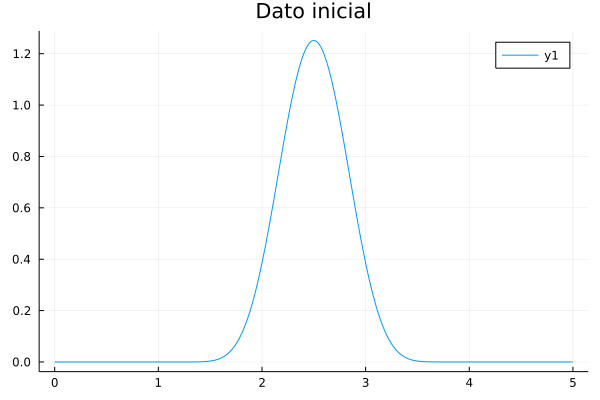

In [27]:
plot(x , u[:,1] , title= "Dato inicial")

In [28]:
prob = ODEProblem(scheme!,u,tspan,par);


In [29]:
sol = solve(prob,SSPRK33(),dt=dt, saveat = T/100);

┌ Info: Saved animation to 
│   fn = C:\Users\LENOVO\CursoPDE\2021\Numericos\Tarea_4\burgerss.gif
└ @ Plots C:\Users\LENOVO\.julia\packages\Plots\HcxwM\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\LENOVO\\CursoPDE\\2021\\Numericos\\Tarea_4\\burgerss.gif")
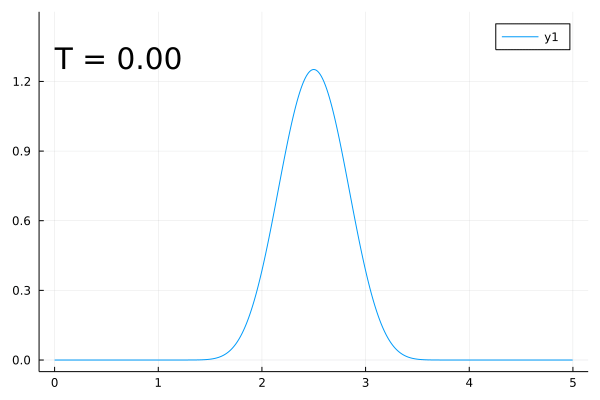

In [30]:
using Printf
anim = @animate for t in sol.t
    plt = plot(x, sol(t), ylims = (-0.05,1.5))
    annotate!(plt, 0.0, 1.3, text("T = $(@sprintf("%.2f", t))", :black, :left, 20))
end
gif(anim, "burgerss.gif", fps = 20)

#### MonotonicityPreserving5

In [31]:
KurganovTadmor = false
MonotonicityPreserving5 =  true
#KurganovTadmor = true
#MonotonicityPreserving5 =  false

true

In [32]:
#Elegimos el método que queremos ver
if KurganovTadmor == true
    θ = 2.0  #Este valor tiene que estar entre 1 y 2. Mientras más cerca de 2, menor disipación.
             #Para sistemas de ecuaciones es mejor que esté más cerca de 1 para evitar oscilaciones.
    auxvectors = createKTauxvectors(N_FIELDS)
    scheme! = KT!
    par = (eqpars, h, θ, Flux_x!, SpeedMax, N, N_FIELDS, auxvectors)
    println("Elegido el método KT")
elseif MonotonicityPreserving5 == true
    auxvectors = createMP5auxvectors(N_FIELDS)
    scheme! = mp5!
    par = (eqpars, h, N, N_FIELDS, Flux_x!, SpeedMax, auxvectors)
    println("Elegido el método MP5")
end

Elegido el método MP5


In [33]:
probMP5 = ODEProblem(scheme!,u,tspan ,par);

In [34]:
solMP5 = solve(probMP5,SSPRK33(),dt=dt, saveat = T/100);

#### Diferencias finitas orden 4

In [43]:
function create_D_4_per(N) #Derivada primera cuarto orden
    D_4_per = BandedMatrix{Float64}(Zeros(N,N), (N-1,N-1))
    D_4_per[band(0)] .= 0.0
    D_4_per[band(1)] .= 2.0/3.0
    D_4_per[band(-1)] .= -2.0/3.0
    D_4_per[band(2)] .= -1.0/12.0
    D_4_per[band(-2)] .= 1.0/12.0
    
    D_4_per[band(N-1)] .= -2.0/3.0
    D_4_per[band(N-2)] .= 1.0/12.0
    
    D_4_per[band(-N+1)] .= 2.0/3.0
    D_4_per[band(-N+2)] .= -1.0/12.0
    
    D_4_per = sparse(D_4_per)
    dropzeros!(D_4_per)
    return D_4_per
end


function create_D2_2_per(N) #Derivada seg
    D2_2_per = BandedMatrix{Float64}(Zeros(N,N), (N-1,N-1))
    D2_2_per[band(0)] .= -2.0
    D2_2_per[band(1)] .= 1.0
    D2_2_per[band(-1)] .= 1.0
    
    D2_2_per[band(N-1)] .= 1.0
    D2_2_per[band(-N+1)] .= 1.0
    
    D2_2_per = sparse(D2_2_per)
    dropzeros!(D2_2_per)
    return D2_2_per
end


create_D2_2_per (generic function with 1 method)

In [44]:
D_4_per = create_D_4_per(N)
D2_2_per = create_D2_2_per(N)

2000×2000 SparseMatrixCSC{Float64, Int64} with 6000 stored entries:
⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈
⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀
⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦

In [45]:
a=1.

function F!(dr,r,p,t) # Funcion generica con las distintas matrices como parametro

 a,dx,D, f = p
    h = 1. /dx
    u = @view r[:,1]
    f .= -0.5.*u.*u
    du = @view dr[:,1]
    mul!(du, D, f, a*h, 0.0) # derivada espacial de la f(u)
end

function Fburgersdis!(dr,r,p,t) # esta es la función de Burgers con un término de viscosidad
    a,dx,D,Diss, f, d = p
    h = 1. /dx
    u = @view r[:,1]
    f .= -0.5.*u.*u
    du = @view dr[:,1]
    mul!(du, D, f, a*h, 0.0)
    
    mul!(d, Diss, u, 0.1*h, 0.0)
    du .= du .+ d[:,1]
end

f = similar(u) #inicializamos vectores donde cargaremos terminos de la ec
d = similar(u);

In [48]:
p4 = (a,dx, D_4_per, f, d); 
p4b = (a,dx, D_4_per, D2_2_per, f, d)
prob4 = ODEProblem(F!,u,tspan,p4);
probburgers4 = ODEProblem(Fburgersdis!,u,(0.0,T),p4b);


In [47]:
sol4 = solve(prob4,RK4(),dt=dt,saveat=T/100);

In [49]:
solburgers4 = solve(probburgers4,RK4(),dt=dt, saveat = T/100);

┌ Info: Saved animation to 
│   fn = C:\Users\LENOVO\CursoPDE\2021\Numericos\Tarea_4\compevol.gif
└ @ Plots C:\Users\LENOVO\.julia\packages\Plots\HcxwM\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\LENOVO\\CursoPDE\\2021\\Numericos\\Tarea_4\\compevol.gif")
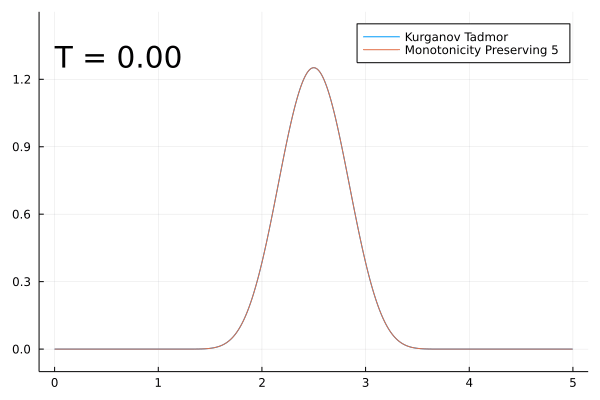

In [53]:

anim = @animate for t in sol.t
    plt = plot(x, sol(t),ylim=(-0.1,1.5), label="Kurganov Tadmor")
    plot!(x, solMP5(t),label="Monotonicity Preserving 5")
     #plot!(x, solburgers4(t),label="Dif finitas orden 4 con disip")
    annotate!(plt, 0.0, 1.3, text("T = $(@sprintf("%.2f", t))", :black, :left, 20))
end
gif(anim, "compevol.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = C:\Users\LENOVO\CursoPDE\2021\Numericos\Tarea_4\comparacion.gif
└ @ Plots C:\Users\LENOVO\.julia\packages\Plots\HcxwM\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\LENOVO\\CursoPDE\\2021\\Numericos\\Tarea_4\\comparacion.gif")
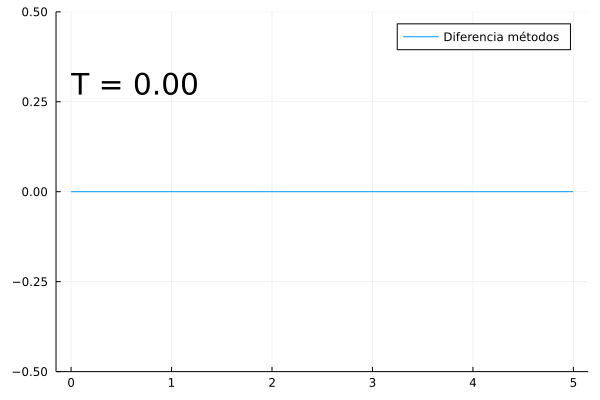

In [54]:
anim = @animate for t in solMP5.t
    plt = plot(x, sol(t)-solMP5(t),ylim=(-0.5,0.5), label="Diferencia métodos")
    #plot!(x, sol(t)-solburgers4(t),ylim=(-0.5,0.5), label="Diferencia  de KT con dif finitas")
    #plot!(x, solMP5(t)-solburgers4(t),ylim=(-0.5,0.5), label="Diferencia de MP5 con dif finitas")
    annotate!(plt, 0.0, 0.3, text("T = $(@sprintf("%.2f", t))", :black, :left, 20))
end
gif(anim, "comparacion.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = C:\Users\LENOVO\CursoPDE\2021\Numericos\Tarea_4\O(4).gif
└ @ Plots C:\Users\LENOVO\.julia\packages\Plots\HcxwM\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\LENOVO\\CursoPDE\\2021\\Numericos\\Tarea_4\\O(4).gif")
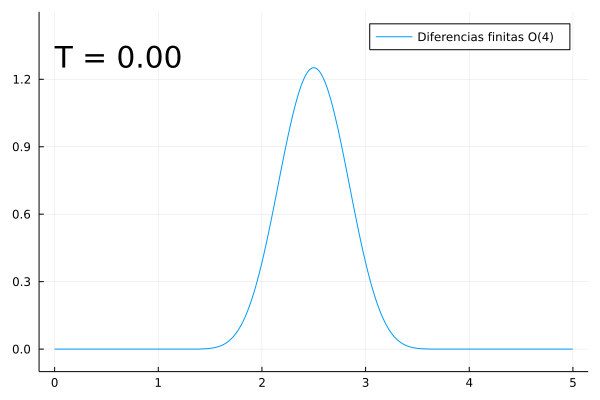

In [51]:
anim = @animate for t in sol4.t
    plt = plot(x, sol4(t), ylim=(-0.1,1.5),label="Diferencias finitas O(4) ")
    annotate!(plt, 0.0, 1.3, text("T = $(@sprintf("%.2f", t))", :black, :left, 20))
end
gif(anim, "O(4).gif", fps = 5)